In [1]:
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from pygsp.graphs import Graph

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils

PATH = '../results/theorems/'
SEED = 0
np.random.seed(SEED)

## Characterize graph models

In [2]:
def characterize_graph(G):
    N = G.N
    A = np.asarray(G.W.todense())
    min_degree =  np.min(np.sum(A, 1))
    D_root_inv = np.diag(1/np.sqrt(np.sum(A, 1)))
    A = D_root_inv.dot(A.dot(D_root_inv))
    L_A, V_A = utils.ordered_eig(A)
    
    # Print summary
    max_links = N*(N-1)/2
    print('N:', N, ':')
    print('\t- norm A:', np.linalg.norm(A))
    print('\t- Proportion of links:', G.Ne/max_links)
    print('\t- Min degree:', min_degree)
    print('\t- First eigenvalues:', L_A[:15])
    
    plt.figure()
    plt.imshow(A)
    plt.title('N: ' + str(N) + ' A norm')
    plt.figure()
    plt.stem(L_A, use_line_collection=True)
    plt.title('Eigenvalues of A')
    
def plot_expexted_A(Gs, n_samples):
    E_A = np.zeros((Gs['N'], Gs['N']))
    for i in range(n_samples):
        E_A += ds.create_graph(Gs, SEED).W.todense()
    E_A /= n_samples
    plt.figure()
    plt.imshow(E_A)
    plt.title('Expected A')

## Check eigenvector similarity

In [3]:
np.random.seed(SEED)

# Graph parameters
GRAPHS = [{'Gs': {'type': ds.SBM, 'k': 8, 'type_z': ds.CONT, 'p':0.8, 'q': 0.05}, 'K': 8, 'leg': 'SBM'},
          {'Gs': {'type': ds.CAVE, 'l': 8}, 'K': 8, 'leg': 'CAVE'},
          {'Gs': {'type': ds.REG, 'd': 0.4}, 'K': 1, 'leg': 'REG'},
          {'Gs': {'type': ds.SW, 'k': 0.25, 'p': 0.25}, 'K': 5, 'leg': 'SW'},
          {'Gs': {'type': ds.PLC, 'm': 0.1, 'p': 0.3}, 'K': 1, 'leg': 'PLC'},
         ]

# Filter parameters
L = 3
hs = np.random.rand(L)
hs /= np.sum(hs)
h_params = {'type': 'FixedH', 'S': 'A', 'hs': hs, 'H_norm': False}

n_graphs = 50
KK = [None]
NN = [50, 100, 500, 1000, 2000]

In [4]:
err_eigvec = np.zeros((len(KK), len(NN), len(GRAPHS), n_graphs))
mean_err_eigvec = np.zeros((len(KK), len(NN), len(GRAPHS), n_graphs))

start_time = time.time()
for i, graph in enumerate(GRAPHS):
    print(graph['leg'] + ':', end=' ')
    for j, N in enumerate(NN):
        graph['Gs']['N'] = N
        for g in range(n_graphs):
            G = ds.create_graph(graph['Gs'], SEED)
            A = np.asarray(G.W.todense())
            D_root_inv = np.diag(1/np.sqrt(np.sum(A, 1)))
            A = D_root_inv.dot(A.dot(D_root_inv))
            L_A, V_A = utils.ordered_eig(A)

            # Calculate Exp Jacobian
            H = utils.create_filter(A, h_params)
            H2 = H.dot(H.T)
            H_norm = H/np.linalg.norm(H, axis=0)
            H2_norm = H_norm.T.dot(H_norm)
            H2_norm[H2_norm>1] = 1
            Z = 1-np.arccos(H2_norm)/np.pi
            E_JJ = 0.5*Z*(H2)

            L_E_JJ, V_E_JJ = utils.ordered_eig(E_JJ)
            V_E_JJ = utils.choose_eig_sign(V_E_JJ, V_A)

            for k in range(len(KK)):
                K = KK[k]
                if KK[k] is None:
                    K = graph['K']
                if K < 1:
                    K = int(KK[k]*N)

                err_eigvec[k, j, i, g] = np.linalg.norm(V_A[:, :K]-V_E_JJ[:, :K],'fro')
                mean_err_eigvec[k, j, i, g] = err_eigvec[k, j, i, g]/K 
        print(N, end=' ')
    print()
    
print('\n--- {} minutes ---'.format((time.time()-start_time)/60))


SBM: 50 100 500 1000 2000 
CAVE: 50 100 500 1000 2000 
REG: 50 100 500 1000 2000 
SW: 50 100 500 1000 2000 
PLC: 50 100 500 1000 2000 

--- 283.02372725009917 minutes ---


## Plot eigenvector ratio

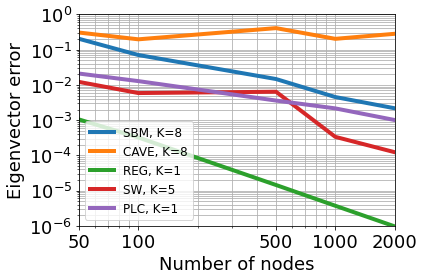

In [5]:
legend_K = []
legend_noK = []
for i, gs in enumerate(GRAPHS):
    legend_K.append('{}, K={}'.format(gs['leg'], gs['K']))
    legend_noK.append('{}'.format(gs['leg']))

legend = legend_K
med_err_eigvec = np.median(err_eigvec, axis=3)
med_mean_err_eigvec = np.median(mean_err_eigvec, axis=3)
for k in range(len(KK)):
    if k == 1:
        legend = legend_noK
    
    f2 = plt.figure()
    plt.loglog(NN, med_mean_err_eigvec[k], linewidth=4)
    plt.legend(legend, prop={'size': 12})
    plt.grid(True, which='both')
    plt.xlabel('Number of nodes',fontsize=18)
    plt.ylabel('Eigenvector error',fontsize=18)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim([1e-6, 1])
    plt.xticks(fontsize=18, ticks=NN, labels=NN)
    plt.yticks(fontsize=18)
    plt.tight_layout()

In [6]:
plt.show()